# Goodreads Book Reviews Analysis - Sample 10,000

## Purpose:
This notebook contains the core thematic analysis pipeline applied to a 10,000-record sample of 1-star reviews from the UCSD Goodreads dataset. It was developed to enable scalable natural language processing and topic extraction before applying to the full dataset.

## Focus:
	•	Clean and normalize review text
	•	Apply rule-based theme tagging with keyword dictionaries
	•	Use Non-negative Matrix Factorization (NMF) to extract themes from uncategorized reviews
	•	Re-assign updated themes and simplify them into primary categories (top_theme)
	•	Generate visualizations to explore patterns in dissatisfaction

## Outcome:
This notebook is the analytical heart of the project and showcases how user complaints can be interpreted, structured, and visualized using scalable NLP workflows.

## Adding dataset with text reviews

In [5]:
import pandas as pd
import json
import gzip
import ast
from collections import Counter

In [6]:
pip install "numpy<2"

Note: you may need to restart the kernel to use updated packages.


In [7]:
import os 

In [8]:
df_1star = pd.read_csv("../Data/1star_reviews.csv")
df_1star.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 419874 entries, 0 to 419873
Data columns (total 20 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Unnamed: 0          419874 non-null  int64  
 1   book_id             419874 non-null  int64  
 2   review_id           419874 non-null  object 
 3   rating              419874 non-null  int64  
 4   review_text         419874 non-null  object 
 5   n_votes             419874 non-null  int64  
 6   isbn                328665 non-null  object 
 7   text_reviews_count  419874 non-null  float64
 8   country_code        419874 non-null  object 
 9   language_code       340979 non-null  object 
 10  popular_shelves     419874 non-null  object 
 11  average_rating      419874 non-null  float64
 12  description         419874 non-null  object 
 13  authors             419874 non-null  object 
 14  publisher           347484 non-null  object 
 15  publication_year    358879 non-nul

In [9]:
# taking a sample of the smallest rating dataset to test for cleaning
sample_1star= df_1star.sample(10000, random_state=42)

In [10]:
sample_1star.head(40)

,Unnamed: 0,book_id,review_id,rating,review_text,n_votes,isbn,text_reviews_count,country_code,language_code,popular_shelves,average_rating,description,authors,publisher,publication_year,url,image_url,ratings_count,title
41230,1546952,7193907,3e2be6da1816bb630e23acd3f28c56d6,1,I usually like Diana Palmer but this one was a...,0,037317649X,58.0,US,eng,"[{'count': '587', 'name': 'to-read'}, {'count'...",3.93,"A spellbinding new installment in the Long, Ta...","[{'author_id': '12692', 'role': ''}]",Harlequin Books,2010.0,https://www.goodreads.com/book/show/7193907-to...,https://s.gr-assets.com/assets/nophoto/book/11...,1358.0,"Tough To Tame (Long, Tall Texans, #38)"
95710,3605557,22816087,f48e8acd876b66649b097305c7de0d22,1,Torture. Pure torture. That is how I describe ...,0,NaN,5741.0,US,eng,"[{'count': '25568', 'name': 'to-read'}, {'coun...",3.98,What would happen if the world were ending?\nA...,"[{'author_id': '545', 'role': ''}]",NaN,2015.0,https://www.goodreads.com/book/show/22816087-s...,https://images.gr-assets.com/books/1449142000m...,47286.0,Seveneves
142885,5308778,14398781,f733fa2faccdd4908ee90437554ded42,1,"Utterly stupid, glad I didn't pay for it. I sk...",0,NaN,407.0,US,eng,"[{'count': '247', 'name': 'currently-reading'}...",3.89,Identity theft regency style.\nFunny. Sexy. Cr...,"[{'author_id': '9811019', 'role': ''}]",Corvallis Press,2012.0,https://www.goodreads.com/book/show/14398781-r...,https://images.gr-assets.com/books/1448305898m...,2810.0,Ridiculous
238919,8889556,12753231,3ecba459e73706bb0cdfbdfe6fc64452,1,I listened to this on audiobook. First of all ...,0,0312569033,2405.0,US,eng,"[{'count': '1075', 'name': 'to-read'}, {'count...",3.89,Your mother hollers that you're going to miss ...,"[{'author_id': '5241601', 'role': ''}]",Feiwel & Friends,2012.0,https://www.goodreads.com/book/show/12753231-m...,https://images.gr-assets.com/books/1337779838m...,17718.0,"Monument 14 (Monument 14, #1)"
172222,6428688,16007164,af80f8a4a1ac0fb2f0dd0a628345dfba,1,Could not get through this book.,0,NaN,8.0,US,en-US,"[{'count': '5446', 'name': 'to-read'}, {'count...",4.06,"London 1872 -\nA bloody escape, a deadly threa...","[{'author_id': '3023434', 'role': ''}]",Fair Wind Publishing,2012.0,https://www.goodreads.com/book/show/16007164-t...,https://images.gr-assets.com/books/1347594718m...,45.0,"The Torn Wing (The Faerie Ring, #2)"
303205,11380092,9844,bff9767404156379b67133e467de29ef,1,"I feel like the Shiba picture says it all, and...",2,081297235X,4163.0,US,eng,"[{'count': '15998', 'name': 'to-read'}, {'coun...",3.36,"Curtis Sittenfeld's debut novel, Prep, is an i...","[{'author_id': '6429', 'role': ''}]",Random House Trade Paperbacks,2005.0,https://www.goodreads.com/book/show/9844.Prep,https://s.gr-assets.com/assets/nophoto/book/11...,51082.0,Prep
191077,7133751,25329731,695574a8393834e79ba149d375387551,1,*Book Received in Exchange for Honest Opinion/...,0,1610055373,5.0,US,eng,"[{'count': '41', 'name': 'to-read'}, {'count':...",3.29,"""I knew it. As I lie on a white bed in a white...","[{'author_id': '13803451', 'role': ''}]",BookLogix,2014.0,https://www.goodreads.com/book/show/25329731-n...,https://images.gr-assets.com/books/1428616076m...,13.0,Nothing But Your Memories
226358,8453271,2381785,fd50c99975da340cdfccb41e739c3c26,1,While I usually really enjoy John Ringo's writ...,1,1416555536,131.0,US,NaN,"[{'count': '468', 'name': 'to-read'}, {'count'...",3.95,In the second decade of the twenty-first centu...,"[{'author_id': '14219', 'role': ''}]",Baen,2008.0,https://www.goodreads.com/book/show/2381785.Th...,https://s.gr-assets.com/assets/nophoto/book/11...,1694.0,The Last Centurion
119477,4477195,25430899,b0b44dcfc84c70a89d06c0697709c31c,1,"If I could give this book no stars I would, it...",0,NaN,529.0,US,en-CA,"[{'count': '3714', 'name': 'to-read'}, {'count...",3.42,Chloe's scarred face makes her the school's fr...,"[{'author_id': '8312760', 'role': ''}]",Young Ink,2016.0,https://www.goodreads.com/book/show/25430899-c...,htt

In [11]:
# Step 1: Create a cleaned language column but keep NaNs
sample_1star = sample_1star[
    sample_1star['language_code'].isna() |
    sample_1star['language_code'].str.lower().str.contains(r'\ben\b|\beng\b|en-', na=False)
]

In [12]:
sample_1star['language_code'].value_counts(dropna=False)

language_code
eng      5701
NaN      1863
en-US    1150
en-GB     293
en-CA      60
Name: count, dtype: int64

In [13]:
!pip install langdetect

In [14]:
from langdetect import detect
import langdetect

def detect_language(text):
    try:
        return detect(text)
    except langdetect.lang_detect_exception.LangDetectException:
        return "unknown"

# Add 'lang' column to sample_1star
sample_1star['lang'] = sample_1star['review_text'].apply(detect_language)

# Filter for English reviews and assign to df_clean
sample_1star = sample_1star[sample_1star['lang'] == 'en'].reset_index(drop=True)

In [15]:
import re

def clean_text(text):
    if pd.isna(text):
        return ""
    
    text = text.lower()                            # Lowercase
    text = re.sub(r'<[^>]+>', '', text)            # Remove HTML tags
    text = re.sub(r'\s+', ' ', text)               # Normalize whitespace
    text = re.sub(r'http\S+', '', text)            # Remove URLs
    text = re.sub(r'[^a-z0-9\s.,!?\'"-]', '', text)  # Remove special characters except common punctuation
    text = text.strip()                            # Trim leading/trailing whitespace
    return text

In [16]:
sample_1star['review_clean'] = sample_1star['review_text'].apply(clean_text)
sample_1star['description_clean'] = sample_1star['description'].apply(clean_text)

In [17]:
sample_1star.sample(40)

,Unnamed: 0,book_id,review_id,rating,review_text,n_votes,isbn,text_reviews_count,country_code,language_code,...,authors,publisher,publication_year,url,image_url,ratings_count,title,lang,review_clean,description_clean
3725,4328694,226486,1b8fe5bbec786ab303960f6da4c87477,1,"The worst Dick I've read, by far. Boring and f...",0,0375719288,137.0,US,eng,...,"[{'author_id': '4764', 'role': ''}]",NaN,NaN,https://www.goodreads.com/book/show/226486.Cla...,https://s.gr-assets.com/assets/nophoto/book/11...,3054.0,Clans of the Alphane Moon,en,"the worst dick i've read, by far. boring and f...",when cia agent chuck rittersdorf and his psych...
1905,5016126,13572846,bc0bd39db513124b4a3d3e3160025841,1,By far the weakest of the TG books. The story ...,0,0857687433,7.0,US,NaN,...,"[{'author_id': '273456', 'role': ''}, {'author...",Titan Books,2012.0,https://www.goodreads.com/book/show/13572846-t...,https://images.gr-assets.com/books/1333579755m...,47.0,Tank Girl: Carioca,en,by far the weakest of the tg books. the story ...,tank girl returns again in a brand new graphic...
3468,14455764,2235597,43f9a2a7800051f24487f077b9e35838,1,"Ouch... OUCH, Patterson... damn... \n James Pa...",0,0316002925,1390.0,US,en-US,...,"[{'author_id': '3780', 'role': ''}, {'author_i...",NaN,NaN,https://www.goodreads.com/book/show/2235597.Th...,https://images.gr-assets.com/books/1266659390m...,14407.0,"The Dangerous Days of Daniel X (Daniel X, #1)",en,"ouch... ouch, patterson... damn... james patte...",he was born with great power the greatest supe...
1857,11908913,8584686,47c1b5b3b468fe125c3d099a6f88372d,1,Couldn't finish. Terrible.,0,0307263991,6367.0,US,eng,...,"[{'author_id': '26417', 'role': ''}]",Knopf,2011.0,https://www.goodreads.com/book/show/8584686-sw...,https://images.gr-assets.com/books/1320536498m...,39404.0,Swamplandia!,en,couldn't finish. terrible.,from the celebrated twenty-nine-year-old autho...
1167,6786501,22668925,78a3becca2b384a4a9e742bb8ac77a9d,1,I am so angry at this author I probably should...,0,077831748X,123.0,US,NaN,...,"[{'author_id': '4496242', 'role': ''}]",Mira,2015.0,https://www.goodreads.com/book/show/22668925-w...,https://images.gr-assets.com/books/1415677242m...,799.0,War of the Wives,en,i am so angry at this author i probably should...,think marriage means happily ever after? think...
1023,9459894,32051723,1ba4203cd125c71d3993729c17a5a275,1,I cannot remember the last time I gave a one-s...,6,006245384X,59.0,US,eng,...,"[{'author_id': '4027380', 'role': ''}]",HarperTeen,2017.0,https://www.goodreads.com/book/show/32051723-d...,https://images.gr-assets.com/books/1487957129m...,184.0,"Dividing Eden (Dividing Eden, #1)",en,i cannot remember the last time i gave a one-s...,twins carys and andreus were never destined to...
6741,8915224,9414170,6c03b4a3847368ca4cb126dcef9d7152,1,"This manga was fantastic! said no one, ever. \...",11,0316119415,57.0,US,eng,...,"[{'author_id': '14470', 'role': ''}, {'author_...",Yen Press,2011.0,https://www.goodreads.com/book/show/9414170-th...,https://images.gr-assets.com/books/1306944993m...,2255.0,"The Betrayal Knows My Name, Volume 01",en,"this manga was fantastic! said no one, ever. t...",abandoned as a baby and raised in an orphanage...
3974,2792145,12015704,9502141afed7418da86f3a64a79e1962,1,VERY rarely do I put a book down but I can't p...,0,006199717X,27.0,US,NaN,...,"[{'author_id': '2884275', 'role': ''}]",William Morrow Paperbacks,2012.0,https://www.goodreads.com/book/show/12015704-t...,https://s.gr-assets.com/assets/nophoto/book/11...,240.0,The Pioneer Woman: Black Heels to Tractor Whee...,en,very rarely do i put a book down but i can't p...,new york timesbestseller wildly popular award-...
6031,5756824,17450112,2dcd6b8779072213f019b10df1358516,1,Complete and utter shit. Everyone should petit...,0,NaN,16.0,US,eng,...,"[{'author_id': '91382', 'role': ''}]",Amber Allure,2013.0,https://www.goodreads.com/book/show/17450112-a...,https://images.gr-assets.com/books/1363858937m...,189.0,"An Unexpected Magic

In [18]:
sample_1star.columns

Index(['Unnamed: 0', 'book_id', 'review_id', 'rating', 'review_text',
       'n_votes', 'isbn', 'text_reviews_count', 'country_code',
       'language_code', 'popular_shelves', 'average_rating', 'description',
       'authors', 'publisher', 'publication_year', 'url', 'image_url',
       'ratings_count', 'title', 'lang', 'review_clean', 'description_clean'],
      dtype='object')

In [19]:
pip install textblob

Note: you may need to restart the kernel to use updated packages.


In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob

In [21]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


# A look into review text with and without NLP

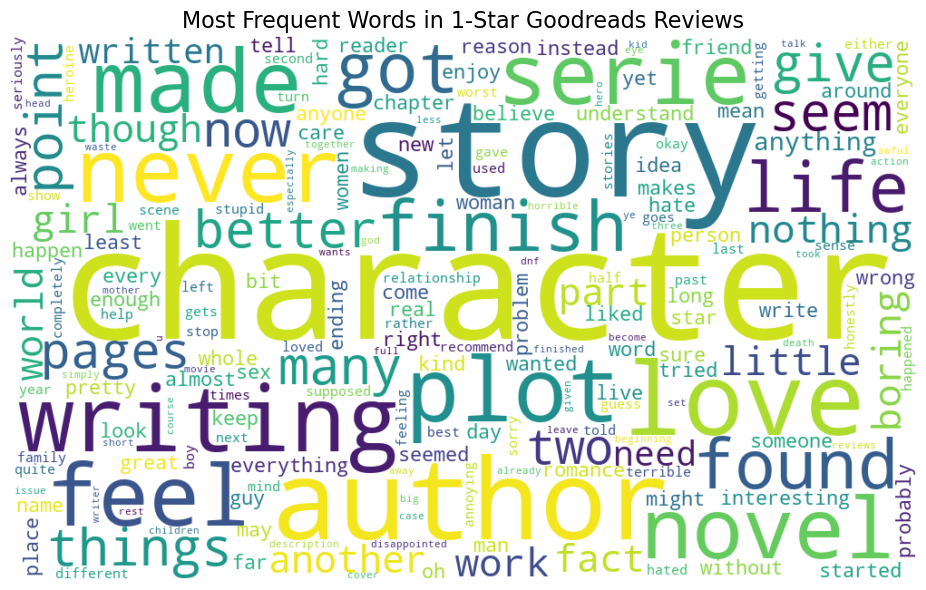

In [23]:
from wordcloud import WordCloud, STOPWORDS

# Combine all review text into one big string
all_reviews = " ".join(review for review in sample_1star['review_clean'].dropna())

# Define stopwords to exclude common words
custom_stopwords = set(STOPWORDS)
custom_stopwords.update([ 'book', 'read', 'one', 'really', 'even', 'get', 'know', 'make', 'thing',
    'think', 'way', 'page', 
     'time','would', 'could', 'like', 'well', 'just', 'books',
    'say', 'thought', 'felt', 'want', 'back', 'reading', 'see', 'go', 'going',
    'take', 'something', 'much', 'still', 'good', 'bad', 'end', 'start',
    'main', 'people', 'done', 'felt', 'lot', 'actually', 'put', 'will', 'first', 'use',
    'maybe', 'find', 'say', 'said', 'try', 'trying', 'readers', 'review','books', 'reading', 'one', 'like'
])  

# Generate the word cloud
wordcloud = WordCloud(width=1000, height=600, background_color='white',
                      stopwords=custom_stopwords, max_words=200).generate(all_reviews)

# Plot it
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Frequent Words in 1-Star Goodreads Reviews", fontsize=16)
plt.tight_layout()
plt.show()

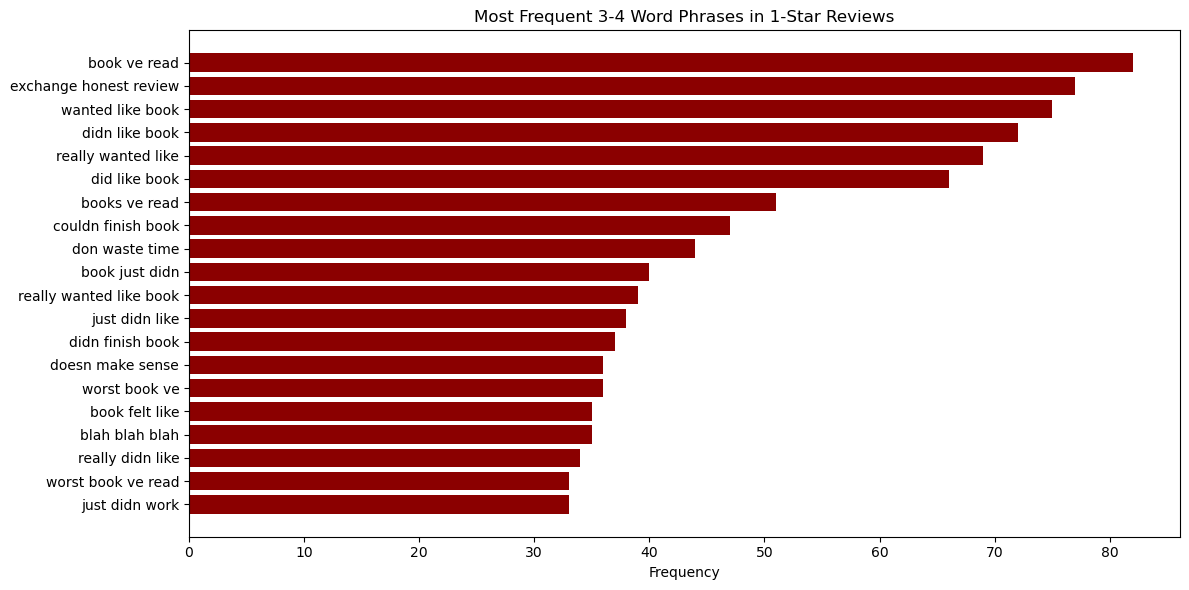

In [24]:
from sklearn.feature_extraction.text import CountVectorizer

# Use bigrams and trigrams
vectorizer = CountVectorizer(ngram_range=(3, 4), stop_words='english', max_features=100)
X = vectorizer.fit_transform(sample_1star['review_clean'].dropna())

# Sum the frequencies
sum_words = X.sum(axis=0)
phrases_freq = [(phrase, sum_words[0, idx]) for phrase, idx in vectorizer.vocabulary_.items()]
phrases_freq = sorted(phrases_freq, key=lambda x: x[1], reverse=True)

# Convert to DataFrame
ngram_df = pd.DataFrame(phrases_freq, columns=['Phrase', 'Frequency'])

# Display top results
plt.figure(figsize=(12,6))
plt.barh(ngram_df['Phrase'][:20][::-1], ngram_df['Frequency'][:20][::-1], color='darkred')
plt.title('Most Frequent 3-4 Word Phrases in 1-Star Reviews')
plt.xlabel('Frequency')
plt.tight_layout()
plt.show()

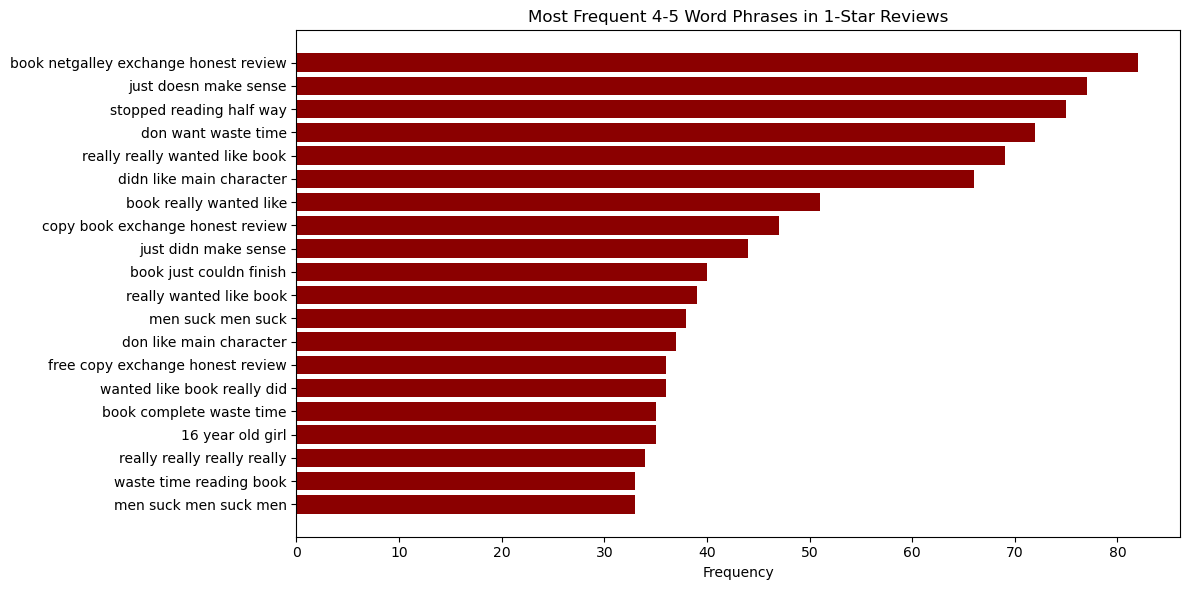

In [25]:
from sklearn.feature_extraction.text import CountVectorizer

# Use bigrams and trigrams
vectorizer2 = CountVectorizer(ngram_range=(4, 5), stop_words='english', max_features=100)
X_2 = vectorizer2.fit_transform(sample_1star['review_clean'].dropna())

# Sum the frequencies
sum_words2 = X_2.sum(axis=0)
phrases_freq2 = [(phrase, sum_words[0, idx]) for phrase, idx in vectorizer2.vocabulary_.items()]
phrases_freq2 = sorted(phrases_freq2, key=lambda x: x[1], reverse=True)

# Convert to DataFrame
ngram2_df = pd.DataFrame(phrases_freq2, columns=['Phrase', 'Frequency'])

# Display top results
plt.figure(figsize=(12,6))
plt.barh(ngram2_df['Phrase'][:20][::-1], ngram2_df['Frequency'][:20][::-1], color='darkred')
plt.title('Most Frequent 4-5 Word Phrases in 1-Star Reviews')
plt.xlabel('Frequency')
plt.tight_layout()
plt.show()

In [26]:
ngram2_df.head(20)

,Phrase,Frequency
0,book netgalley exchange honest review,82
1,just doesn make sense,77
2,stopped reading half way,75
3,don want waste time,72
4,really really wanted like book,69
5,didn like main character,66
6,book really wanted like,51
7,copy book exchange honest review,47
8,just didn make sense,44
9,book just couldn finish,40


In [27]:
# Theme mapping dictionary: theme → list of indicative phrases/keywords
complaint_themes = {
    'Character Issues': [
        'main character', 'character development', 'year old', 'immature', 'annoying', 'love interest',
        'unlikable', 'flat character', 'cardboard cutout', 'inconsistent character',
        'poorly developed', 'shallow', 'unlikeable', 'irritating', 'stupid character',
        'weak character', 'flawed character', 'sympathy for', 'no connection with',
        'motivations unclear', 'acted out of character', 'forced relationship',
        'insta-love', 'toxic relationship', 'protagonist', 'antagonist',
        'side character', 'underdeveloped characters', 'one-dimensional',
        'contrived motivations', 'unbelievable actions', 'lack of depth',
        'superficial', 'self-absorbed', 'whiny', 'passive', 'aggressive',
        'jerk', 'bitch', 'mary sue', 'gary stu', 'author insert',
        'wish fulfillment character', 'unearned development',
        'rushed character arc', 'stagnant character', 'rely on stereotypes'
    ],
    'Plot/Structure': [
        'storyline', 'plot', 'spoiler alert', 'twist', 'didn make sense', 'nothing happened',
        'predictable', 'rushed ending', 'slow burn', 'pacing issues', 'convoluted plot',
        'plot holes', 'deus ex machina', 'uneven pacing', 'anticlimactic', 'pointless subplot',
        'disjointed', 'rambling', 'contrived', 'repetitive plot points', 'no resolution',
        'weak plot', 'thin plot', 'overly complicated', 'underdeveloped plot',
        'too much exposition', 'info dump', 'lack of focus', 'meandering',
        'circular narrative', 'incoherent', 'illogical', 'unrealistic plot',
        'convenient coincidences', 'forced conflict', 'lack of stakes',
        'unnecessary scenes', 'padding', 'false climax', 'unsatisfying ending',
        'cliffhanger with no payoff', 'sequel baiting', 'felt incomplete'
    ],
    'Writing Style': [
        'writing style', 'bad writing', 'purple prose', 'repetitive', 'boring', 'poorly written',
        'clunky prose', 'awkward phrasing', 'stilted dialogue', 'unnatural dialogue',
        'telling not showing', 'over descriptive', 'underdeveloped', 'simplistic writing',
        'pretentious writing', 'amateurish', 'grammatical errors', 'typos', 'editing issues',
        'poor sentence structure', 'weak vocabulary', 'monotonous', 'flow issues',
        'choppy', 'dense writing', 'impenetrable', 'overuse of adjectives',
        'clichés', 'hackneyed', 'trite', 'melodramatic', 'overwrought',
        'infodumping through dialogue', 'dialogue felt forced',
        'internal monologue overuse', 'head hopping', 'inconsistent tense'
    ],
    'Engagement': [
        'couldn finish', 'waste time', 'feel like', 'just didn', 'didn like', 'slow', 'dragged',
        'lost interest', 'tedious', 'struggled to get through', 'hard to follow',
        'unengaging', 'dull', 'plodding', 'sleep-inducing', 'wish i hadn read',
        'skimming', 'couldn\'t connect', 'no emotional impact', 'didn care about',
        'wanted it to end', 'a chore to read', 'painful to read', 'eyes glazed over',
        'mind wandered', 'checked page count constantly', 'felt like a slog',
        'momentum stalled', 'pacing was off', 'never invested', 'no suspense',
        'lacked excitement', 'failed to captivate'
    ],
    'Expectations vs Reality': [
        'like book', 'expected', 'thought would', 'overhyped',
        'not what i expected', 'misleading description', 'different from summary',
        'disappointed', 'underwhelming', 'fell flat', 'not as good as', 'wasted potential',
        'false advertising', 'bait and switch', 'promised more than delivered',
        'didn live up to the hype', 'genre wasn\'t what i thought',
        'cover was misleading', 'title was misleading', 'blurb was inaccurate',
        'reviews were misleading', 'fanbase is delusional'
    ],
    'Offensive Content': [
        'offensive', 'problematic', 'sexist', 'racist', 'abuse', 'trigger',
        'misogynistic', 'homophobic', 'ableist', 'culturally insensitive',
        'gory', 'disturbing', 'gratuitous violence', 'sexual assault',
        'animal cruelty', 'hate speech', 'stereotypes', 'colorism', 'fatphobia',
        'victim blaming', 'glorification of violence', 'romanticizing abuse',
        'toxic masculinity', 'white savior trope', 'bury your gays trope',
        'fridging', 'rape as plot device', 'unnecessary graphic detail'
    ],
    'Genre Mismatch': [
        'not romance', 'not fantasy', 'genre', 'more thriller than',
        'felt like', 'marketed as', 'supposed to be', 'wrong genre',
        'elements of', 'blended genres poorly', 'not enough',
        'too much [genre element]', 'this isn\'t [genre]', 'where\'s the',
        'misleading genre tag', 'didn fit the category', 'cross-genre failure',
        'felt like a different genre entirely', 'no present'
    ]
}

In [28]:
def assign_themes(review_text, theme_map):
    review_text = review_text.lower()
    matched_themes = []

    for theme, keywords in theme_map.items():
        if any(kw in review_text for kw in keywords):
            matched_themes.append(theme)

    return matched_themes if matched_themes else ['Uncategorized']

In [29]:
# Apply the theme assignment to your cleaned reviews
sample_1star['complaint_themes'] = sample_1star['review_clean'].apply(
    lambda x: assign_themes(x, complaint_themes)
)

In [30]:
from collections import Counter
from itertools import chain

# Flatten list of themes and count
theme_counts = Counter(chain.from_iterable(sample_1star['complaint_themes']))
print(theme_counts.most_common())

[('Uncategorized', 3795), ('Plot/Structure', 1904), ('Character Issues', 1772), ('Writing Style', 1389), ('Engagement', 1240), ('Genre Mismatch', 768), ('Expectations vs Reality', 673), ('Offensive Content', 475)]


In [31]:
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import STOPWORDS
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from nltk.stem import WordNetLemmatizer

# Assuming your DataFrame is named 'sample_1star'
uncategorized_df = sample_1star[sample_1star['complaint_themes'].apply(lambda x: 'Uncategorized' in x)].copy()
uncategorized_reviews = uncategorized_df['review_clean'].dropna().tolist()

# 1. Define Stopwords (using your combined list)
nltk_stopwords = set(stopwords.words('english'))
wordcloud_stopwords = set(STOPWORDS)
custom_stopwords = set([
    'book', 'read', 'one', 'really', 'even', 'get', 'know', 'make', 'thing',
    'think', 'way', 'page', 'time', 'would', 'could', 'like', 'well', 'just', 'books',
    'say', 'thought', 'felt', 'want', 'back', 'reading', 'see', 'go', 'going',
    'take', 'something', 'much', 'still', 'good', 'bad', 'end', 'start',
    'main', 'people', 'done', 'felt', 'lot', 'actually', 'put', 'will', 'first', 'use',
    'maybe', 'find', 'say', 'said', 'try', 'trying', 'readers', 'review'
])
combined_stopwords_set = nltk_stopwords.union(wordcloud_stopwords).union(custom_stopwords)

# 2. Lemmatization and Stopword Removal for Uncategorized Reviews
lemmatizer = WordNetLemmatizer()
processed_uncategorized_reviews = []
for review in uncategorized_reviews:
    tokens = word_tokenize(review.lower())
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    processed_tokens = [token for token in lemmatized_tokens if token not in combined_stopwords_set]
    processed_uncategorized_reviews.append(" ".join(processed_tokens))

# 3. Feature Extraction with TF-IDF for Uncategorized Reviews
tfidf_vectorizer_uncat = TfidfVectorizer(stop_words=list(combined_stopwords_set),
                                        ngram_range=(1, 3),
                                        max_df=0.90,
                                        min_df=2)
tfidf_matrix_uncat = tfidf_vectorizer_uncat.fit_transform(processed_uncategorized_reviews)
feature_names_uncat = tfidf_vectorizer_uncat.get_feature_names_out()

# 4. Train the NMF Model for Uncategorized Reviews
num_topics_uncat = 7  # You can experiment with the number of topics for the uncategorized data
nmf_model_uncat = NMF(n_components=num_topics_uncat, random_state=42, max_iter=300)
nmf_model_uncat.fit(tfidf_matrix_uncat)

# 5. Analyze the Topics for Uncategorized Reviews
print("\nNMF Topics for Uncategorized Reviews:")
for topic_idx, topic in enumerate(nmf_model_uncat.components_):
    top_words_indices = topic.argsort()[:-21:-1]
    top_words = [feature_names_uncat[i] for i in top_words_indices]
    print(f"Uncategorized Topic {topic_idx + 1}: {' '.join(top_words)}")

# 6. Get Topic Assignments for Uncategorized Reviews (Optional)
doc_topic_matrix_uncat = nmf_model_uncat.transform(tfidf_matrix_uncat)
dominant_topics_uncat = [row.argmax() + 1 for row in doc_topic_matrix_uncat]

# 7. Add NMF Topic Assignments to the Uncategorized DataFrame (Optional)
uncategorized_df['nmf_topic_uncat'] = pd.Series(dominant_topics_uncat, index=uncategorized_df.index[:len(dominant_topics_uncat)])

# Merge the NMF topic assignments back into the original DataFrame
sample_1star = pd.merge(sample_1star, uncategorized_df[['review_id', 'nmf_topic_uncat']], on='review_id', how='left')

print("\nDataFrame with NMF Topic Labels for Uncategorized (First 10):")
print(sample_1star[['review_clean', 'complaint_themes', 'nmf_topic_uncat']].head(10))

/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['let'] not in stop_words.
  warnings.warn(



NMF Topics for Uncategorized Reviews:
Uncategorized Topic 1: story character author ca never ha series star doe give love writing terrible got many better life made short chapter
Uncategorized Topic 2: finish ca finish finish wa gave ca chapter wa finish bothered finish got started bothered tried club struggled finish plan started finish force saying bored ring
Uncategorized Topic 3: hated ugh school school hated sorry reason enough finish hated everything ugh hated hated wa disappointment finished absolutely hated high school hated remember high school stupid feel hated character
Uncategorized Topic 4: wa wa wa awful written wa written finish wa bored wa awful wa terrible story wa writing wa free impressed ending wa better wa bored hard enjoyed wa horrible better
Uncategorized Topic 5: worst waste ugh wa worst horrible probably worst waste money probably worst long money horror long worst worst bit ending far worst far possibly worst quite possibly worst quite possibly
Uncategorized 

In [32]:
complaint_themes_updated = {
    'Character Issues': [
        'main character', 'character development', 'year old', 'immature', 'annoying', 'love interest',
        'unlikable', 'flat character', 'cardboard cutout', 'inconsistent character',
        'poorly developed', 'shallow', 'unlikeable', 'irritating', 'stupid character',
        'weak character', 'flawed character', 'sympathy for', 'no connection with',
        'motivations unclear', 'acted out of character', 'forced relationship',
        'insta-love', 'toxic relationship', 'protagonist', 'antagonist',
        'side character', 'underdeveloped characters', 'one-dimensional',
        'contrived motivations', 'unbelievable actions', 'lack of depth',
        'superficial', 'self-absorbed', 'whiny', 'passive', 'aggressive',
        'jerk', 'bitch', 'mary sue', 'gary stu', 'author insert',
        'wish fulfillment character', 'unearned development',
        'rushed character arc', 'stagnant character', 'rely on stereotypes',
        'stupid', 'hate'  # Added from Strong Negative Sentiment
    ],
    'Plot/Structure': [
        'storyline', 'plot', 'spoiler alert', 'twist', 'didn make sense', 'nothing happened',
        'predictable', 'rushed ending', 'slow burn', 'pacing issues', 'convoluted plot',
        'plot holes', 'deus ex machina', 'uneven pacing', 'anticlimactic', 'pointless subplot',
        'disjointed', 'rambling', 'contrived', 'repetitive plot points', 'no resolution',
        'weak plot', 'thin plot', 'overly complicated', 'underdeveloped plot',
        'too much exposition', 'info dump', 'lack of focus', 'meandering',
        'circular narrative', 'incoherent', 'illogical', 'unrealistic plot',
        'convenient coincidences', 'forced conflict', 'lack of stakes',
        'unnecessary scenes', 'padding', 'false climax', 'unsatisfying ending',
        'cliffhanger with no payoff', 'sequel baiting', 'felt incomplete',
        'story' # Added from Uncategorized Topic 1 and 4
    ],
    'Writing Style': [
        'writing style', 'bad writing', 'purple prose', 'repetitive', 'boring', 'poorly written',
        'clunky prose', 'awkward phrasing', 'stilted dialogue', 'unnatural dialogue',
        'telling not showing', 'over descriptive', 'underdeveloped', 'simplistic writing',
        'pretentious writing', 'amateurish', 'grammatical errors', 'typos', 'editing issues',
        'poor sentence structure', 'weak vocabulary', 'monotonous', 'flow issues',
        'choppy', 'dense writing', 'impenetrable', 'overuse of adjectives',
        'clichés', 'hackneyed', 'trite', 'melodramatic', 'overwrought',
        'infodumping through dialogue', 'dialogue felt forced',
        'internal monologue overuse', 'head hopping', 'inconsistent tense',
        'written' # Added from Uncategorized Topic 4
    ],
    'Engagement': [
        'couldn finish', 'waste time', 'feel like', 'just didn', 'didn like', 'slow', 'dragged',
        'lost interest', 'tedious', 'struggled to get through', 'hard to follow',
        'unengaging', 'dull', 'plodding', 'sleep-inducing', 'wish i hadn read',
        'skimming', 'couldn\'t connect', 'no emotional impact', 'didn care about',
        'wanted it to end', 'a chore to read', 'painful to read', 'eyes glazed over',
        'mind wandered', 'checked page count constantly', 'felt like a slog',
        'momentum stalled', 'pacing was off', 'never invested', 'no suspense',
        'lacked excitement', 'failed to captivate',
        'couldn\'t continue', 'gave up', 'stopped reading', 'dnf', 'did not finish',
        'bored', 'finish', 'disappointment', 'wa' # Added from NMF Topics
    ],
    'Expectations vs Reality': [
        'like book', 'expected', 'thought would', 'overhyped',
        'not what i expected', 'misleading description', 'different from summary',
        'disappointed', 'underwhelming', 'fell flat', 'not as good as', 'wasted potential',
        'false advertising', 'bait and switch', 'promised more than delivered',
        'didn live up to the hype', 'genre wasn\'t what i thought',
        'cover was misleading', 'title was misleading', 'blurb was inaccurate',
        'reviews were misleading', 'fanbase is delusional',
        'waste of time', 'waste of money', 'didn\'t feel worth it', 'awful', 'terrible' # Added from NMF Topics
    ],
    'Offensive Content': [
        'offensive', 'problematic', 'sexist', 'racist', 'abuse', 'trigger',
        'misogynistic', 'homophobic', 'ableist', 'culturally insensitive',
        'gory', 'disturbing', 'gratuitous violence', 'sexual assault',
        'animal cruelty', 'hate speech', 'stereotypes', 'colorism', 'fatphobia',
        'victim blaming', 'glorification of violence', 'romanticizing abuse',
        'toxic masculinity', 'white savior trope', 'bury your gays trope',
        'fridging', 'rape as plot device', 'unnecessary graphic detail'
    ],
    'Genre Mismatch': [
        'not romance', 'not fantasy', 'genre', 'more thriller than',
        'felt like', 'marketed as', 'supposed to be', 'wrong genre',
        'elements of', 'blended genres poorly', 'not enough',
        'too much [genre element]', 'this isn\'t [genre]', 'where\'s the',
        'misleading genre tag', 'didn fit the category', 'cross-genre failure',
        'felt like a different genre entirely', 'no present'
    ]
}

In [33]:
def assign_themes_updated(review_text, theme_map):
    review_text = review_text.lower()
    matched_themes = []

    for theme, keywords in theme_map.items():
        if any(kw in review_text for kw in keywords):
            matched_themes.append(theme)

    return matched_themes if matched_themes else ['Uncategorized']

In [34]:
# Apply the updated theme assignment and store in the correct column
sample_1star['complaint_themes_updated'] = sample_1star['review_clean'].apply(
    lambda x: assign_themes_updated(x, complaint_themes_updated)
)

from collections import Counter
from itertools import chain

# Flatten list of themes and count the updated themes
theme_counts_updated = Counter(chain.from_iterable(sample_1star['complaint_themes_updated']))
print(theme_counts_updated.most_common())

print("\nDataFrame with Updated Complaint Themes (First 10):")
print(sample_1star[['review_clean', 'complaint_themes', 'complaint_themes_updated']].head(10))

[('Engagement', 6598), ('Plot/Structure', 3420), ('Character Issues', 2524), ('Writing Style', 1972), ('Expectations vs Reality', 1413), ('Uncategorized', 1064), ('Genre Mismatch', 768), ('Offensive Content', 475)]

DataFrame with Updated Complaint Themes (First 10):
                                        review_clean  \
0  i usually like diana palmer but this one was a...   
1  torture. pure torture. that is how i describe ...   
2  utterly stupid, glad i didn't pay for it. i sk...   
3  i listened to this on audiobook. first of all ...   
4                   could not get through this book.   
5  i feel like the shiba picture says it all, and...   
6  book received in exchange for honest opinionre...   
7  while i usually really enjoy john ringo's writ...   
8  if i could give this book no stars i would, it...   
9  i gave it a 1 because there isn't a lower number.   

                                    complaint_themes  \
0                                [Offensive Content]   
1  

In [35]:
theme_palette = { #distinct under colorblind simulations
    'Engagement': '#1b9e77',          # dark teal
    'Plot/Structure': '#d95f02',      # orange
    'Character Issues': '#7570b3',    # purple-blue
    'Writing Style': '#e7298a',       # reddish pink
    'Expectations vs Reality': '#66a61e',  # olive green
    'Genre Mismatch': '#e6ab02',      # yellow-brown
    'Offensive Content': '#a6761d',   # brown 
    'Uncategorized': '#666666'        # dark gray (if every shown)
}

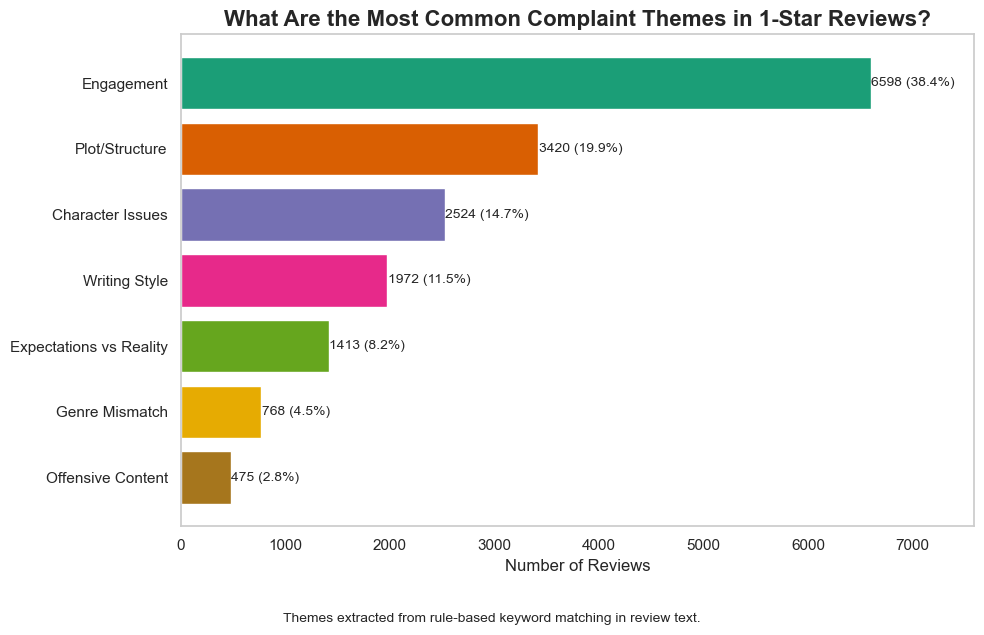

In [46]:
# Filter out 'Uncategorized' and sort by frequency
filtered_theme_counts = {k: v for k, v in theme_counts_updated.items() if k.lower() != 'uncategorized'}
top_themes = sorted(filtered_theme_counts.items(), key=lambda x: x[1], reverse=True)
labels, counts = zip(*top_themes)

# Apply your fixed, colorblind-accessible palette
colors = [theme_palette[label] for label in labels]

# Plot
plt.figure(figsize=(10, 6))
bars = plt.barh(labels, counts, color=colors)

# Title and axis
plt.title("What Are the Most Common Complaint Themes in 1-Star Reviews?", fontsize=16, weight='bold')
plt.xlabel("Number of Reviews", fontsize=12)

# Add value + percentage labels
total = sum(counts)
for bar, count in zip(bars, counts):
    percent = (count / total) * 100
    plt.text(
        bar.get_width() + 5,
        bar.get_y() + bar.get_height() / 2,
        f"{count} ({percent:.1f}%)",
        va='center', fontsize=10
    )

# Visual refinements
plt.gca().invert_yaxis()  # Highest count on top
plt.grid(False)
plt.figtext(0.5, -0.05,
            "Themes extracted from rule-based keyword matching in review text.",
            wrap=True, horizontalalignment='center', fontsize=10)
plt.xlim(0, max(counts) * 1.15)  # Adds 15% padding to the right
plt.tight_layout()

# Save then show
plt.savefig('themes_1star_reviews.jpg', format='jpg', dpi=300, bbox_inches='tight')
plt.show()

In [48]:
pip install adjustText

Note: you may need to restart the kernel to use updated packages.


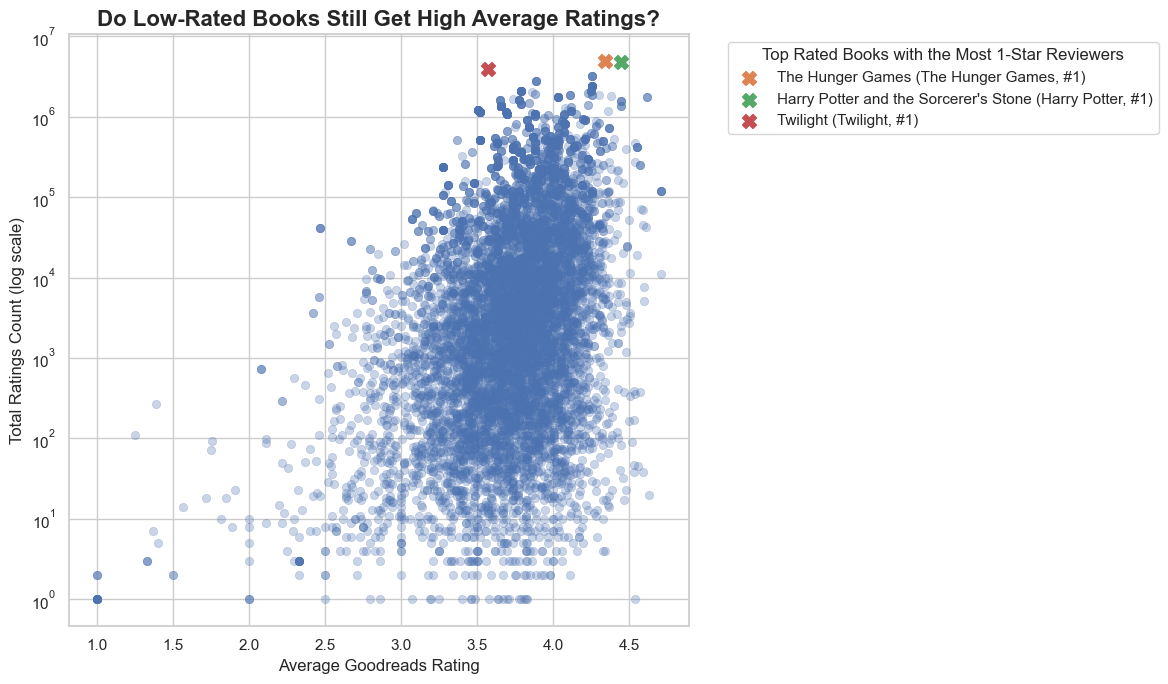

In [64]:
# Set style
sns.set(style="whitegrid")
plt.figure(figsize=(12, 7))

# Base scatterplot
sns.scatterplot(
    data=sample_1star,
    x='average_rating',
    y='ratings_count',
    alpha=0.3,
    edgecolor=None
)

plt.yscale('log')

# Top books — no duplicate titles
top_books = (
    sample_1star.sort_values(by='ratings_count', ascending=False)
    .drop_duplicates(subset='title')
    .head(3)
)

# Highlight top books with custom markers and legend
for _, row in top_books.iterrows():
    plt.scatter(row['average_rating'], row['ratings_count'], s=100, marker='X', label=row['title'], zorder=5)

# Add title and labels
plt.title("Do Low-Rated Books Still Get High Average Ratings?", fontsize=16, fontweight='bold')
plt.xlabel("Average Goodreads Rating", fontsize=12)
plt.ylabel("Total Ratings Count (log scale)", fontsize=12)

# Legend
plt.legend(title='Top Rated Books with the Most 1-Star Reviewers', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig("low_rated_books_high_rating_legend.jpg", format='jpg', dpi=300, bbox_inches='tight')
plt.show()

In [38]:
# Create a new column with the first complaint theme (or 'Uncategorized')

sample_1star['top_theme'] = sample_1star['complaint_themes_updated'].apply(lambda x: x[0] if isinstance(x, list) and x else 'Uncategorized'

)

In [ ]:
# Remove duplicate titles to avoid overplotting books reviewed multiple times
unique_books = sample_1star.drop_duplicates(subset='title')

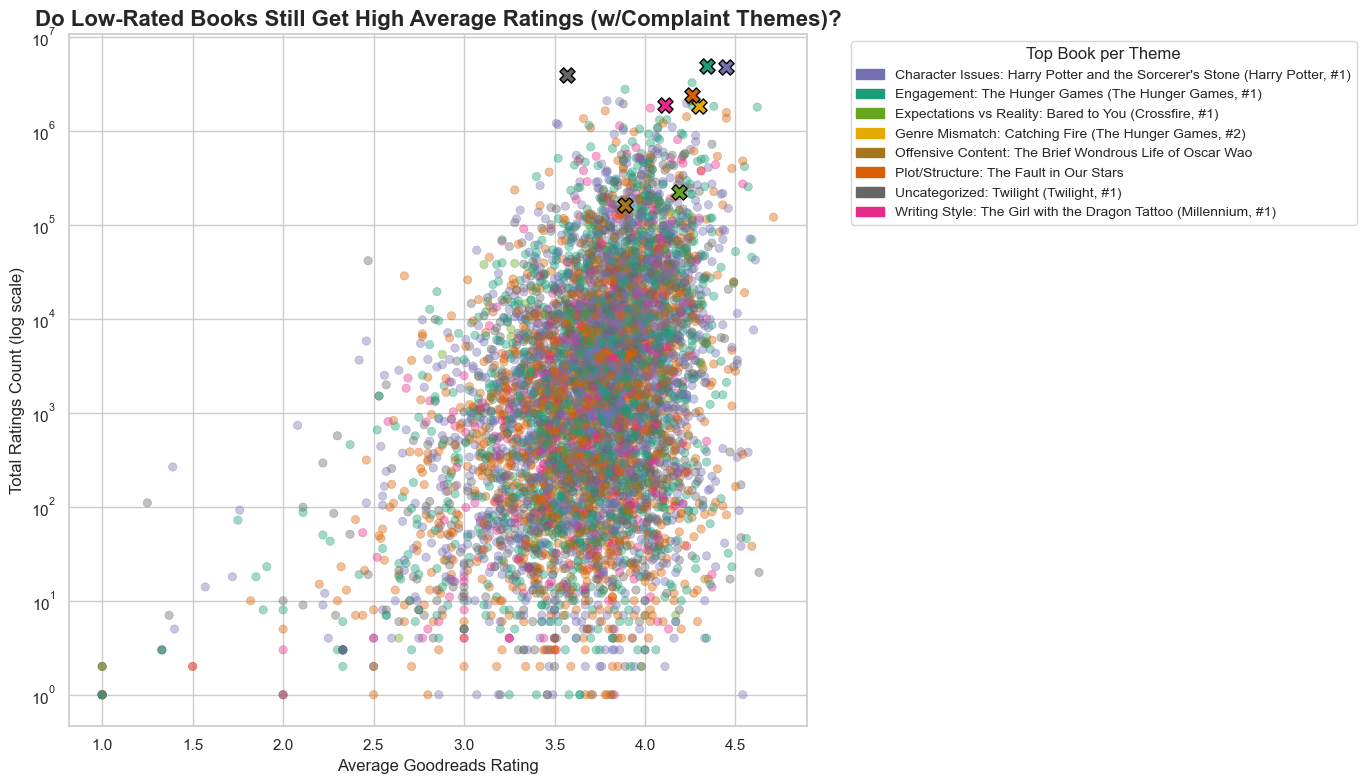

In [70]:
import matplotlib.patches as mpatches

# Drop duplicate book titles to avoid overplotting
unique_books = sample_1star.drop_duplicates(subset='title')

# Get top-rated book (by ratings count) per complaint theme
top_books_by_theme = (
    unique_books
    .sort_values(by='ratings_count', ascending=False)
    .groupby('top_theme')
    .first()
    .reset_index()
)

# Plot setup
plt.figure(figsize=(14, 8))
sns.set(style="whitegrid")

# Base scatterplot
sns.scatterplot(
    data=unique_books,
    x='average_rating',
    y='ratings_count',
    hue='top_theme',
    palette=theme_palette,
    alpha=0.4,
    edgecolor=None
)

# Highlight top books per theme with larger X markers
legend_handles = []
for _, row in top_books_by_theme.iterrows():
    plt.scatter(
        row['average_rating'],
        row['ratings_count'],
        s=120,
        marker='X',
        color=theme_palette.get(row['top_theme'], '#000000'),
        edgecolor='black',
        linewidth=1.0,
        zorder=5
    )
    legend_handles.append(mpatches.Patch(
        color=theme_palette.get(row['top_theme'], '#000000'),
        label=f"{row['top_theme']}: {row['title']}"
    ))

# Axis settings
plt.yscale('log')
plt.xlabel("Average Goodreads Rating", fontsize=12)
plt.ylabel("Total Ratings Count (log scale)", fontsize=12)
plt.title("Do Low-Rated Books Still Get High Average Ratings (w/Complaint Themes)?", fontsize=16, fontweight='bold')

# Combined legend: themes and top books
plt.legend(handles=legend_handles, title="Top Book per Theme", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

plt.tight_layout()
plt.savefig('low_rated_books_by_theme_highlights.jpg', format='jpg', dpi=300, bbox_inches='tight')
plt.show()

/var/folders/2z/wrbf0xfj7dx7p5r_t84w_f8w0000gn/T/ipykernel_24260/3917618155.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


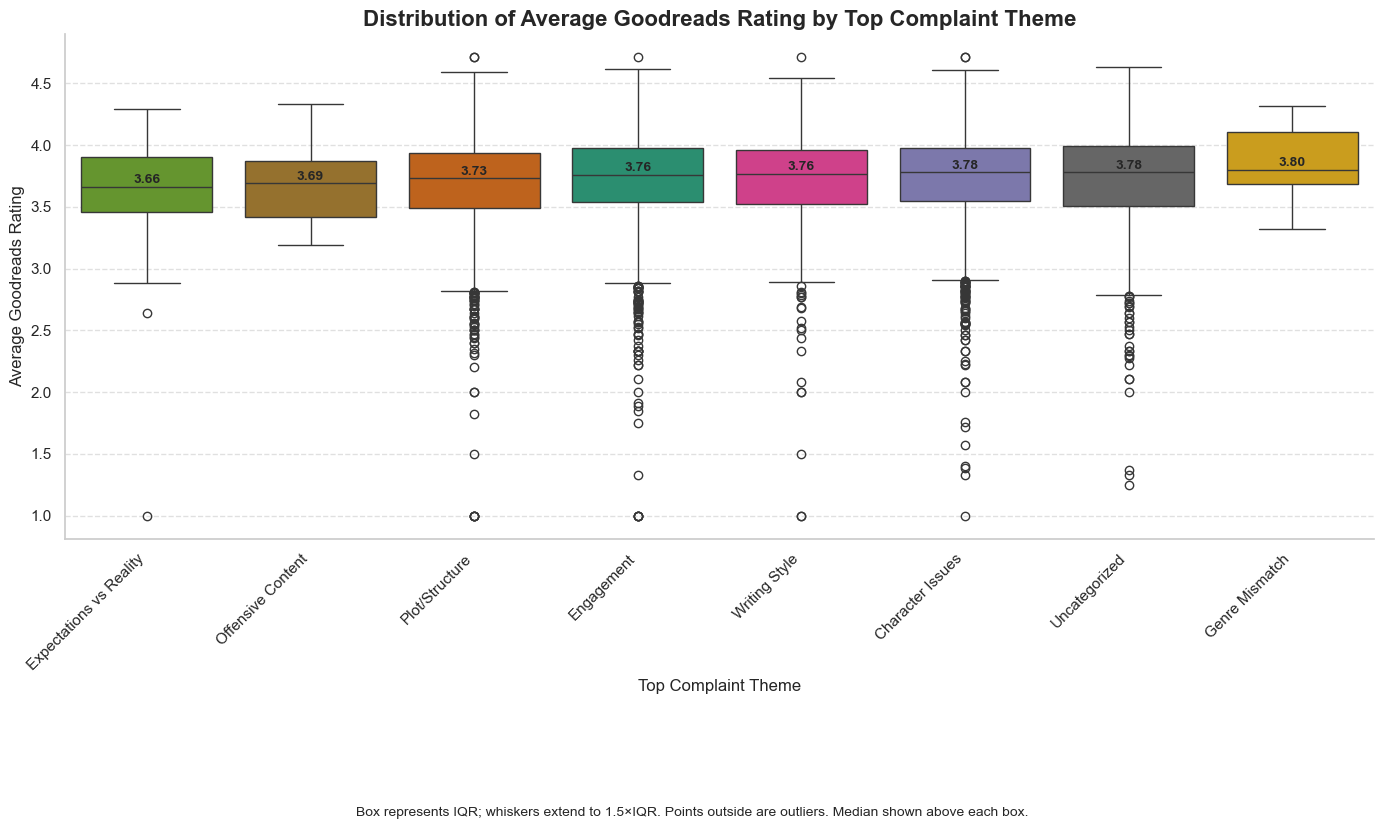

In [72]:
# Sort by median to show themes in order
theme_order = (
    sample_1star.groupby('top_theme')['average_rating']
    .median()
    .sort_values()
    .index
)

plt.figure(figsize=(14, 8))
sns.boxplot(
    x='top_theme',
    y='average_rating',
    data=sample_1star,
    order=theme_order,
    palette=theme_palette
)

# Add median labels above each box
medians = sample_1star.groupby('top_theme')['average_rating'].median().reindex(theme_order)
for i, (theme, median) in enumerate(medians.items()):
    plt.text(i, median + 0.03, f"{median:.2f}", ha='center', fontsize=10, weight='bold')

# Labels and styling
plt.title("Distribution of Average Goodreads Rating by Top Complaint Theme", fontsize=16, fontweight='bold')
plt.xlabel("Top Complaint Theme", fontsize=12)
plt.ylabel("Average Goodreads Rating", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.6)
sns.despine()

# Footnote for interpretation
plt.figtext(0.5, -0.08,
            "Box represents IQR; whiskers extend to 1.5×IQR. Points outside are outliers. Median shown above each box.",
            wrap=True, horizontalalignment='center', fontsize=10)

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.savefig('avg_goodreads_rating_by_theme_boxplot.jpg', format='jpg', dpi=300, bbox_inches='tight')
plt.show()

/var/folders/2z/wrbf0xfj7dx7p5r_t84w_f8w0000gn/T/ipykernel_24260/2536651584.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='top_theme', y='ratings_count', data=sample_1star, palette=theme_palette)


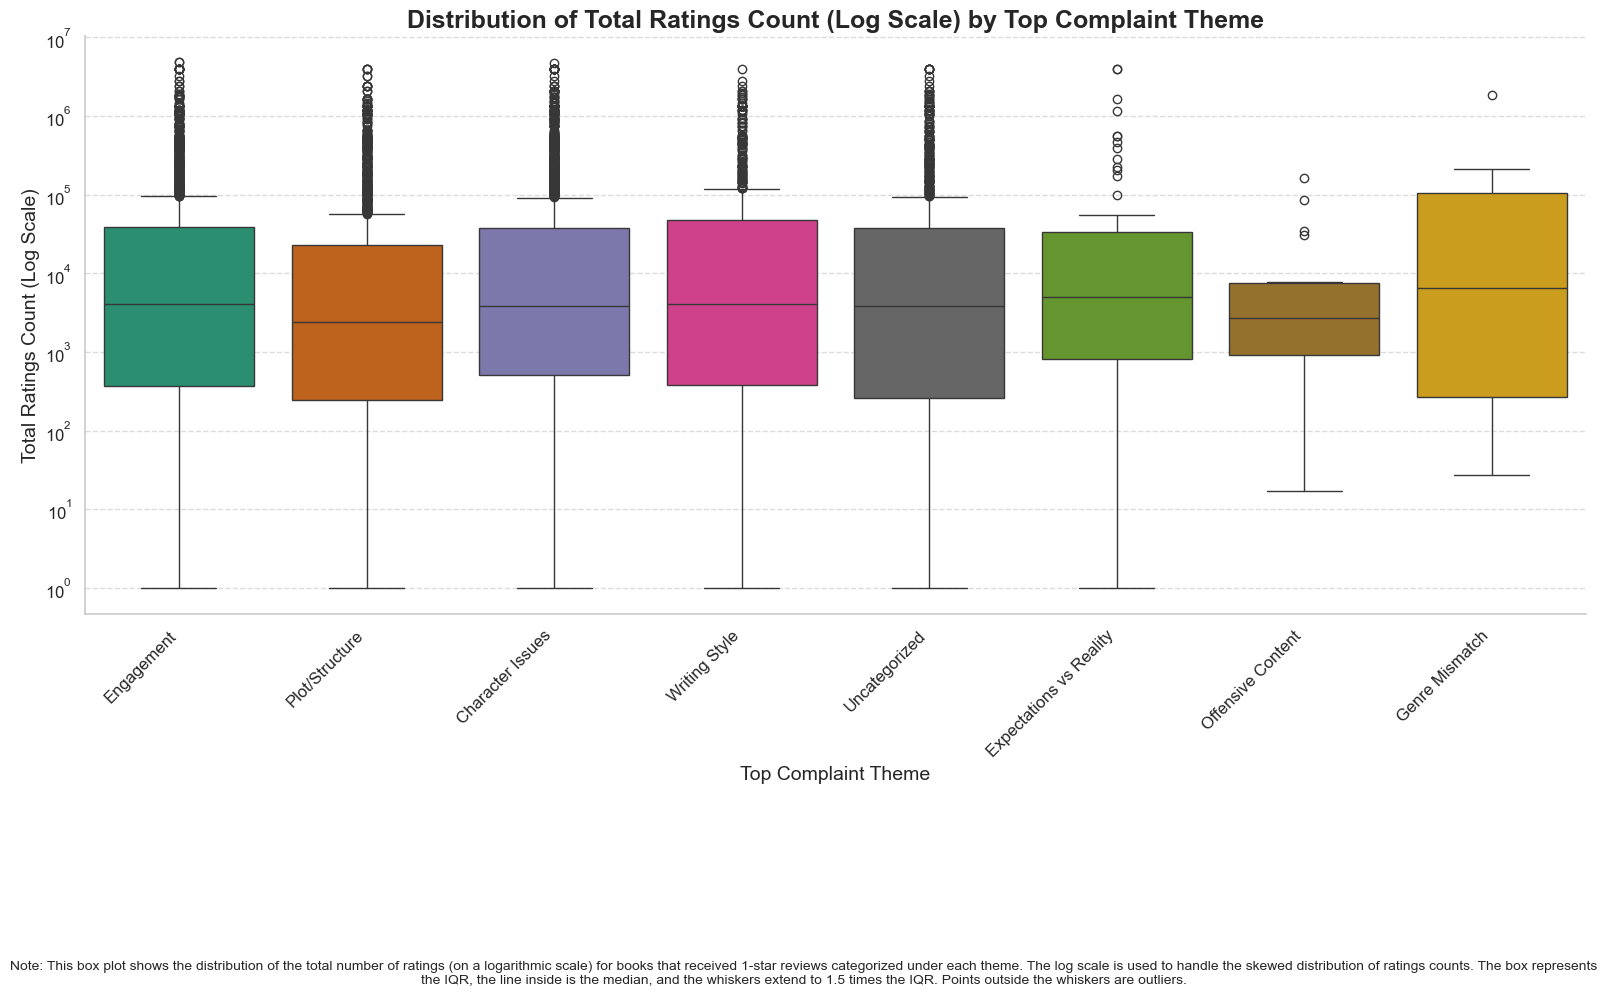

In [41]:
plt.figure(figsize=(16, 9))
sns.boxplot(x='top_theme', y='ratings_count', data=sample_1star, palette=theme_palette)
plt.yscale('log')

plt.title("Distribution of Total Ratings Count (Log Scale) by Top Complaint Theme", fontsize=18, fontweight='bold')
plt.xlabel("Top Complaint Theme", fontsize=14)
plt.ylabel("Total Ratings Count (Log Scale)", fontsize=14)

plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)
sns.despine()

plt.figtext(0.5, -0.15,
            "Note: This box plot shows the distribution of the total number of ratings (on a logarithmic scale) for books that received 1-star reviews categorized under each theme. The log scale is used to handle the skewed distribution of ratings counts. The box represents the IQR, the line inside is the median, and the whiskers extend to 1.5 times the IQR. Points outside the whiskers are outliers.",
            wrap=True, horizontalalignment='center', fontsize=10)

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.savefig('distribution_total_ratings_logscale_by_complaint_theme.jpg', format='jpg', dpi=300, bbox_inches='tight')
plt.show()

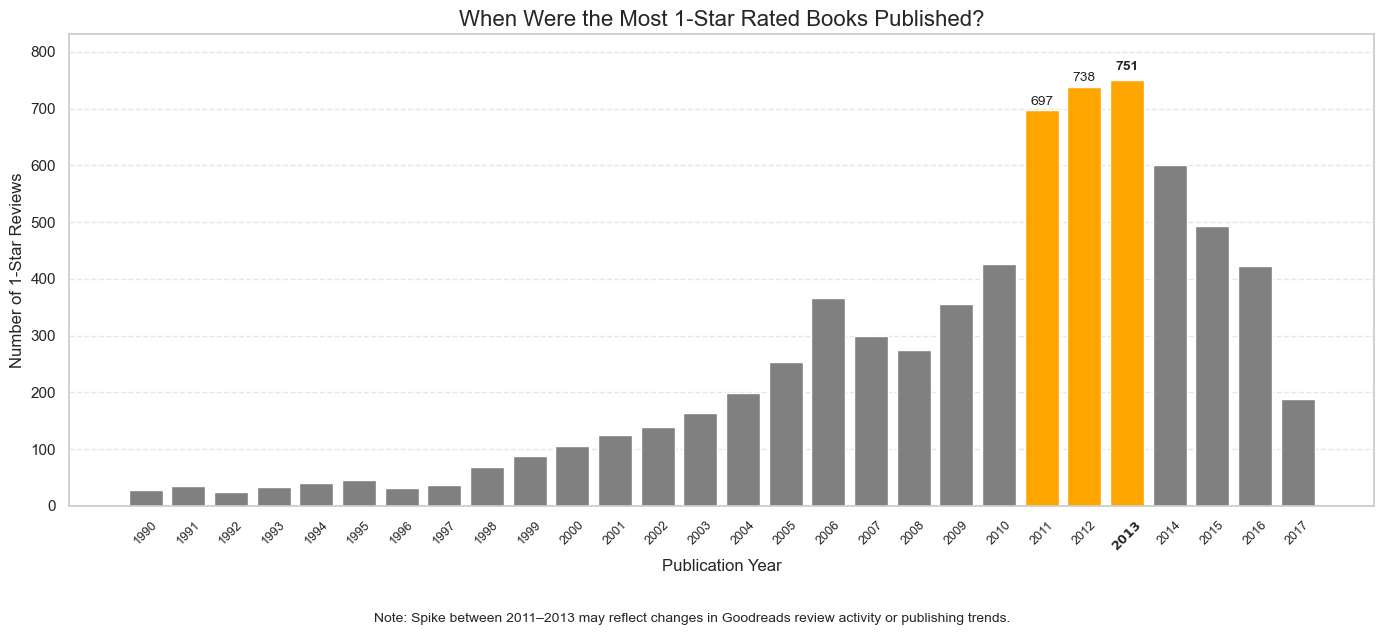

In [74]:
# Get filtered year counts
sample_1star_clean = sample_1star[(sample_1star['publication_year'] >= 1990) & 
                                  (sample_1star['publication_year'] <= 2018)]

# Generate a complete index from 1990–2020 (so every year is shown)
year_range = list(range(1990, 2018))

# Count and reindex to include all years
year_counts = sample_1star_clean['publication_year'].value_counts().sort_index()
year_counts = year_counts.reindex(year_range, fill_value=0)

# --- STEP 2: Plot the Data ---
highlight_years = [2011, 2012, 2013]
colors = ['orange' if year in highlight_years else 'gray' for year in year_counts.index]

fig, ax = plt.subplots(figsize=(14, 6))

bars = ax.bar(year_counts.index, year_counts.values, color=colors)

# Add exact labels for 2011–2013 just above bars (except 2013, which we'll bold separately)
for bar in bars:
    year = int(bar.get_x() + bar.get_width() / 2)
    height = bar.get_height()
    if year in highlight_years and year != 2013:
        ax.text(bar.get_x() + bar.get_width() / 2, height + 5,
                f'{int(height)}', ha='center', va='bottom', fontsize=10)
# Axis settings
ax.set_title("When Were the Most 1-Star Rated Books Published?", fontsize=16)
ax.set_xlabel("Publication Year")
ax.set_ylabel("Number of 1-Star Reviews")
ax.set_xticks(year_range)
# Bold the label for 2013
xtick_labels = []
for year in year_range:
    if year == 2013:
        xtick_labels.append(f'$\\bf{{{year}}}$')  # LaTeX bold
    else:
        xtick_labels.append(str(year))

ax.set_xticklabels(xtick_labels, rotation=45, fontsize=9)
# Remove vertical gridlines
ax.grid(axis='y', linestyle='--', alpha=0.5)
ax.grid(axis='x', visible=False)

# Highlight 2013 value in bold above the bar
highlight_year = 2013
highlight_value = year_counts[highlight_year]

ax.annotate(f'{highlight_value}',
            xy=(highlight_year, highlight_value),
            xytext=(0, 5),
            textcoords='offset points',
            ha='center',
            va='bottom',
            fontsize=10,
            fontweight='bold')  # Make the label bold

# Add padding above the tallest bar
ax.set_ylim(0, year_counts.max() + 80)

# Add a footnote
plt.figtext(0.5, -0.05,
            "Note: Spike between 2011–2013 may reflect changes in Goodreads review activity or publishing trends.",
            wrap=True, horizontalalignment='center', fontsize=10)

plt.tight_layout()
plt.savefig('when_were_most_1star_reviews_published.jpg', format='jpg', dpi=300, bbox_inches='tight')
plt.show()

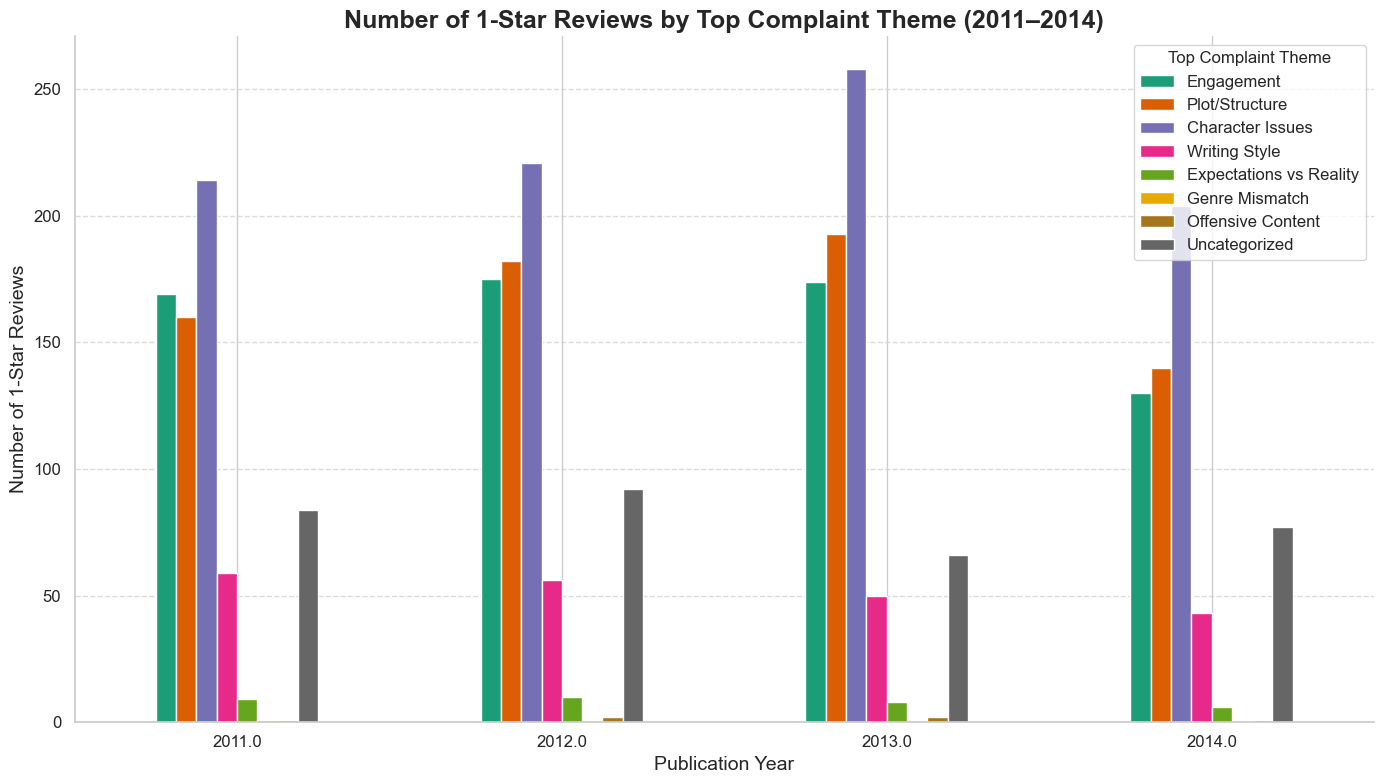

In [76]:
theme_counts_by_year = theme_counts_by_year[theme_palette.keys()]

# Plot
ax = theme_counts_by_year.plot(
    kind='bar',
    figsize=(14, 8),
    color=[theme_palette[col] for col in theme_counts_by_year.columns]
)

# Formatting
ax.set_title("Number of 1-Star Reviews by Top Complaint Theme (2011–2014)", fontsize=18, fontweight='bold')
ax.set_xlabel("Publication Year", fontsize=14)
ax.set_ylabel("Number of 1-Star Reviews", fontsize=14)
ax.tick_params(axis='x', labelrotation=0, labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.legend(title='Top Complaint Theme', fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)
sns.despine()

plt.tight_layout()
plt.savefig('1star_reviews_by_theme_2011_2014.jpg', format='jpg', dpi=300, bbox_inches='tight')
plt.show()

/var/folders/2z/wrbf0xfj7dx7p5r_t84w_f8w0000gn/T/ipykernel_24260/3990530677.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  theme_by_year = sample_1star.groupby('year_bin')['top_theme'].value_counts(normalize=True).unstack(fill_value=0)


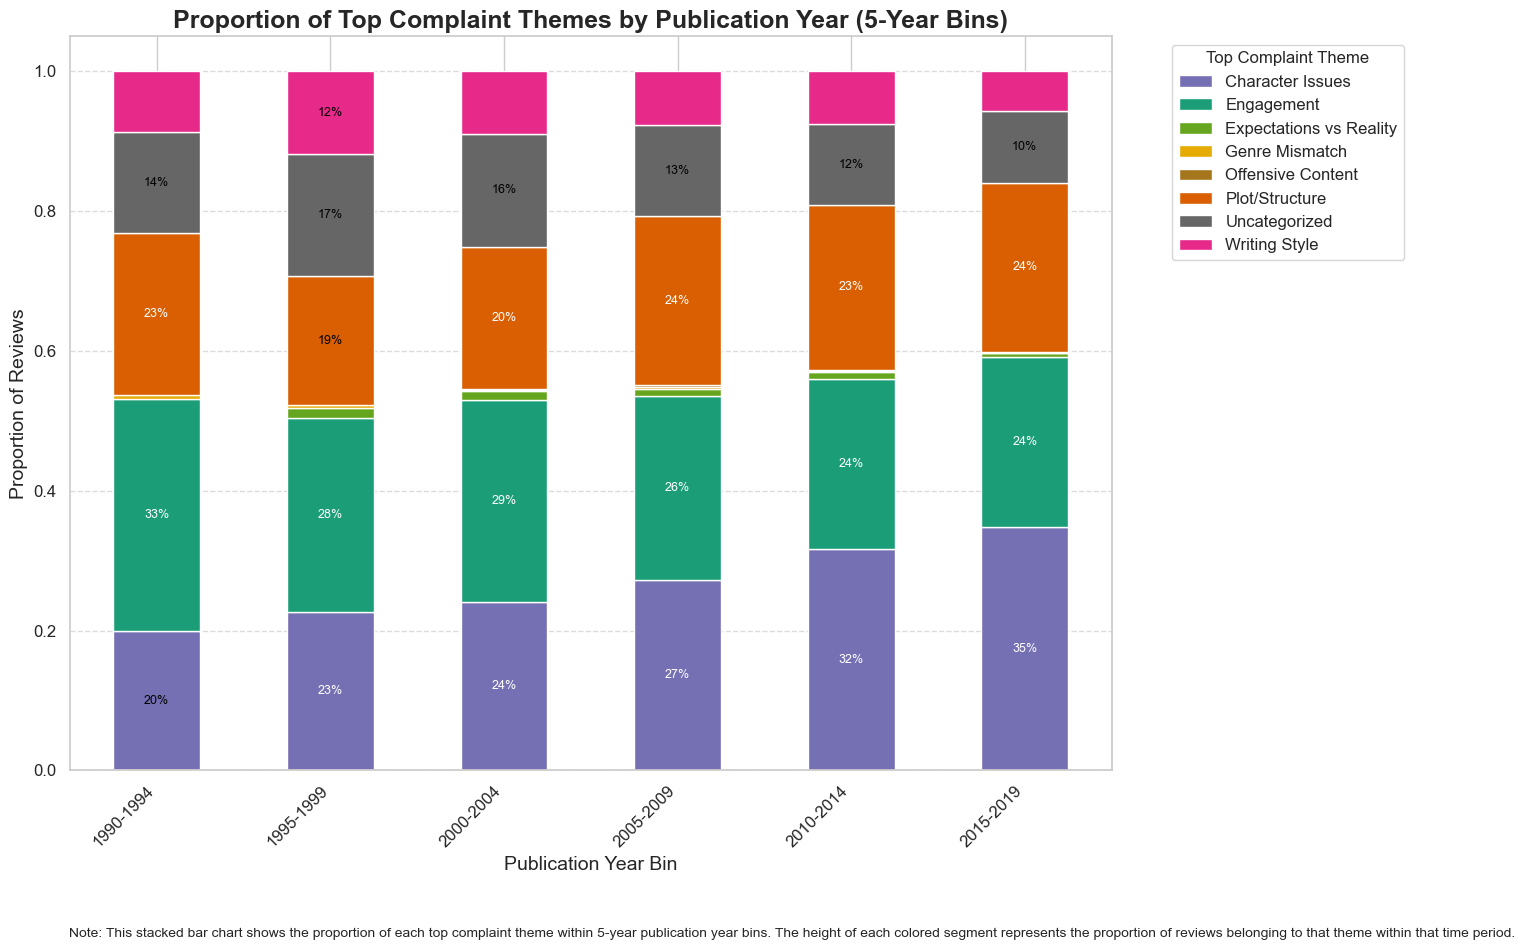

In [82]:
# Create year bins
bins = list(range(1990, 2021, 5))
labels = [f'{i}-{i+4}' for i in bins[:-1]]
sample_1star['year_bin'] = pd.cut(sample_1star['publication_year'], bins=bins, labels=labels, right=False)

# Group by year bin and top_theme
theme_by_year = sample_1star.groupby('year_bin')['top_theme'].value_counts(normalize=True).unstack(fill_value=0)

# Plot
plt.figure(figsize=(16, 9))
ax = theme_by_year.plot(
    kind='bar',
    stacked=True,
    color=[theme_palette.get(col, '#cccccc') for col in theme_by_year.columns],  # apply theme_palette
    ax=plt.gca()
)

plt.title("Proportion of Top Complaint Themes by Publication Year (5-Year Bins)", fontsize=18, fontweight='bold')
plt.xlabel("Publication Year Bin", fontsize=14)
plt.ylabel("Proportion of Reviews", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

plt.legend(title='Top Complaint Theme', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout(rect=[0, 0, 0.9, 1])

# Add percentage labels
for i, bin_label in enumerate(theme_by_year.index):
    y_offset = 0
    for theme in theme_by_year.columns:
        height = theme_by_year.loc[bin_label, theme]
        if height > 0.1:
            plt.text(
                i,
                y_offset + height / 2,
                f'{(height * 100):.0f}%',
                ha='center',
                va='center',
                fontsize=9,
                color='white' if height > 0.2 else 'black'
            )
        y_offset += height

# Add caption
plt.figtext(
    0.5, -0.05,
    "Note: This stacked bar chart shows the proportion of each top complaint theme within 5-year publication year bins. "
    "The height of each colored segment represents the proportion of reviews belonging to that theme within that time period.",
    wrap=True, horizontalalignment='center', fontsize=10
)

# Save and show
plt.savefig('proportion_complaint_themes_by_year_bin.jpg', format='jpg', dpi=300, bbox_inches='tight')
plt.show()

# Optional: Clean up temporary column
sample_1star.drop(columns=['year_bin'], inplace=True)

# A look into shelves - the conundrum of genres

In [ ]:
sample_1star.head()

In [ ]:
#cleaning popular shelves column
print(sample_1star['popular_shelves'].iloc[0])

In [ ]:
#seeing which shelves have the highest counts
#function that extracts shelf names from string lists of the shelf dictionaires
def shelf_names(shelves_str):
    shelves_list = ast.literal_eval(shelves_str) #convert the string to a list of dicts
    if isinstance(shelves_list, list):
        return [shelf['name'] for shelf in shelves_list if 'name' in shelf] #extract 'name' value from each dict if it exists
    return []

shelf_counter = Counter()

In [ ]:
#very large operation (takes about 100 minutes to run)
for row in sample_1star['popular_shelves'].dropna():
    shelf_counter.update(shelf_names(row))

print(shelf_counter.most_common(60))

In [ ]:
import random

unique_shelves = list(shelf_counter.keys())
print(f"unique names: {len(unique_shelves)}")

In [ ]:
import ast

blacklist = [
    # 1. Reading status
    'to-read', 'read-in-2016', 'currently-reading', 'tbr', 'read-2016', 'read-2015', 'read-2014',
    'read-2013', 'read-2012', 'read-2011', 'read-2010', 're-read', 'reread', 'to-reread', 'already-read',
    'read-again', 'read-aloud', 'read-alouds', 'read-fiction', 'read-in-school', 'read-as-a-kid',
    'read-comics', 'read-next', 'read-2009', 'read-in-english',

    # 2. Ownership/location
    'owned', 'my-books', 'library', 'kindle', 'ebooks', 'books-i-own', 'to-buy', 'owned-books',
    'i-own', 'my-library', 'own-it', 'borrowed', 'on-my-shelf', 'books-i-have', 'bookshelf',
    'home-library', 'my-bookshelf', 'own-to-read', 'own-ebook', 'my-ebooks', 'owned-tbr',
    'ebooks-i-own', 'own-kindle', 'owned-not-read', 'owned-but-not-read', 'own-on-kindle',
    'kindle-owned', 'own-unread', 'owned-unread', 'owned-ebook', 'own-a-copy', 'my-kindle-books',
    'owned-kindle', 'own-tbr', 'kindle-library', 'books-owned', 'kindle-to-read', 'not-owned',
    'do-not-own', 'owned-not-read', 'owned-but-not-read', 'own-unread', 'own-a-copy',

    # 3. Format or device
    'audiobook', 'ebook', 'paperback', 'hardcover', 'audiobooks', 'audio', 'e-book', 'e-books',
    'audio-books', 'audio-book', 'audible', 'library-book', 'kindle-books', 'nook', 'on-kindle',
    'netgalley', 'overdrive', 'pdf', 'epub', 'ibooks', 'kobo', 'kindle-unlimited', 'digital',
    'graphic', 'ebook-owned', 'epub', 'e-reader', 'calibre', 'ibooks', 'kobo', 'downloaded',
    'kindle-book', 'ebooks-i-own',

    # 4. Rating/review-based
    '5-stars', 'favorites', 'favourites', 'favorite', 'favorite-books', 'favorite-series',
    'my-favorites', 'favorite-authors', 'favorite-author', 'faves', 'favourite', 'fav',
    'gave-up-on', 'gave-up', 'did-not-finish', 'dnf', 'abandoned', 'unfinished', 'didn-t-finish',
    'couldn-t-finish', 'could-not-finish', 'not-finished', 'not-read', 'never-finished', 'paused',
    'stopped-reading', 'not-for-me', 'nope', 'meh', 'dnf', 'review', 'reviewed',

    # 5. Challenge or year-based
    '2016-reading-challenge', '2017-reading-challenge', '2015-reading-challenge', '2014-read',
    '2015-reads', '2014-reads', '2013-reads', '2012-reads', '2011-reads', '2010-reads', '2016-reads',
    '2015-books', '2014-books', '2013-books', '2012-books', '2017-reads', '2017-books',
    '2017-read', '2017-release', '2017-reading-list', '2017-books-read', 'books-read-in-2016',
    'books-read-in-2015', 'books-read-in-2014', 'books-read-in-2013', 'books-read-in-2012',
    'books-read-in-2017', 'books-read-in-2011', 'books-read-in-2010', 'read-in-2015',
    'read-in-2014', 'read-in-2013', 'read-in-2012', 'read-in-2011', 'read-in-2010', '2016-books',
    '2016-read', '2017-books-read', '2017-books-read', 'books-read-in-2016', '2016-books-read',

    # 6. Meta or personal tags
    'wishlist', 'wish-list', 'book-club', 'bookclub', 'book-club-books', 'book-club-reads',
    'book-group', 'to-re-read', 're-read', 'reread', 'to-reread', 'to-read-owned', 'to-read-own',
    'to-read-fiction', 'to-read-non-fiction', 'to-read-nonfiction', 'to-read-ya', 'to-read-series',
    'to-read-classics', 'to-read-fantasy', 'to-review', 'to-purchase', 'to-be-read', 'to-be-released',
    'to-read-soon', 'to-get', 'want-to-read', 'want-to-buy', 'want', 'need', 'need-to-buy',
    'need-to-get', 'not-interested', 'maybe', 'maybe-read', 'recommendations', 'next', 'next-to-read',
    'next-in-series', 'done', 'shelved', 'my-shelf', 'own-a-copy', 'own-tbr', 'top-tbr', 'not-for-me',
    'considering', 'owned-but-not-read', 'wishlist', 'wishlist', 'owned-to-read'
]


blacklist_words = set(word.lower() for word in blacklist)

In [ ]:
genre_mapping = {
    'cowboys': 'cowboy',
    'chick lit': 'chick lit',
    'adult fiction': 'adult fiction',
    'cowboy western': 'cowboy western',
    'genre western': 'western',
    'romantic suspense': 'romantic suspense',
    'action': 'action',
    'series romance': 'romance',
    'genre romance': 'romance',
    'romance modern': 'modern romance',
    'science fiction': 'science fiction',
    'sci fi': 'science fiction',
    'scifi': 'science fiction',
    'post apocalyptic': 'post apocalyptic',
    'sf': 'science fiction',
    'sci fi fantasy': 'science fiction fantasy',
    'dystopia': 'dystopian',
    'apocalyptic': 'apocalyptic',
    'science': 'science',
    'speculative fiction': 'speculative fiction',
    'fantasy sci fi': 'science fiction fantasy',
    'apocalypse': 'apocalyptic',
    'space opera': 'space opera',
    'science fiction fantasy': 'science fiction fantasy',
    'hard sci fi': 'hard science fiction',
    'sff': 'science fiction fantasy',
    'post apocalypse': 'post apocalyptic',
    'sf fantasy': 'science fiction fantasy',
    'sci fi and fantasy': 'science fiction fantasy',
    'hard scifi': 'hard science fiction',
    'sciencefiction': 'science fiction',
    'regency romance': 'regency romance',
    'romance historical': 'historical romance',
    'mf': 'm f',
    'historical romances': 'historical romance',
    'historicals': 'historical',
    'humorous': 'humor',
    'humour': 'humor',
    'humour comedy': 'humor',
    'young adult': 'young adult',
    'ya': 'young adult',
    'fairies': 'fairies',
    'faeries': 'fairies',
    'faerie': 'fairies',
    'fey': 'fae',
    'ya fantasy': 'young adult fantasy',
    'paranormal romance': 'paranormal romance',
    'historical fantasy': 'historical fantasy',
    'historical fic': 'historical fiction',
    'supernatural': 'supernatural',
    'faries': 'fairies',
    'classic lit': 'classic literature',
    'british lit': 'british literature',
    'brit lit': 'british literature',
    'english lit': 'english literature',
    'lit': 'literature',
    'feminist': 'feminism',
    'ya books': 'young adult books',
    'ya fiction': 'young adult fiction',
    'ya': 'young adult',
    'non fiction': 'nonfiction',
    'non fic': 'nonfiction',
    'distopian': 'dystopian',
    'ya dystopian': 'young adult dystopian',
    'ya lit': 'young adult literature'
}

In [ ]:
genre_mapping.update({
    'women s fiction': 'womens fiction',
    'womens fiction': 'womens fiction', 
    'children s': 'children books',
    'childrens books': 'children books',
    'children s books': 'children books',
    'children': 'children books',
    'childrens': 'children books',
    'kids books': 'children books',
    'kid books': 'children books',
    'general fiction': 'fiction',
    'novels': 'novel',
})

In [ ]:
import ast
from collections import defaultdict

# Helper to clean individual shelf/tag names
def clean_name(name):
    return name.lower().replace('-', ' ').replace('_', ' ').strip()

# Parse the shelf string into a list of (name, count)
def extract_shelves(shelves_str):
    try:
        shelves_list = ast.literal_eval(shelves_str)
    except:
        return []

    if isinstance(shelves_list, list):
        return [(clean_name(shelf['name']), int(shelf.get('count', 0)))
                for shelf in shelves_list if 'name' in shelf]
    return []

# Main cleaning pipeline
def apply_cleaning_pipeline(shelves_str, genre_mapping, blacklist_words):
    # Step 1: Extract and clean
    shelves = extract_shelves(shelves_str)

    # Step 2: Map to standardized genres
    mapped = []
    for tag, count in shelves:
        tag_clean = clean_name(tag)
        mapped_tag = genre_mapping.get(tag_clean, tag_clean)
        mapped.append((mapped_tag, count))

    # Step 3: Remove any mapped tag that contains a blacklisted word
    result = []
    for tag, count in mapped:
        if not any(bad_word in tag for bad_word in blacklist_words):
            result.append((tag, count))

    # Step 4: Aggregate repeated tags
    tag_counts = defaultdict(int)
    for tag, count in result:
        tag_counts[tag] += count

    return sorted(tag_counts.items(), key=lambda x: x[1], reverse=True)

In [ ]:
sample_1star['cleaned_shelves'] = sample_1star['popular_shelves'].apply(
    apply_cleaning_pipeline,
    args=(genre_mapping, blacklist_words)
)

In [ ]:
pd.set_option('display.max_colwidth', None)
sample_1star[['cleaned_shelves']].head(5)

In [ ]:
# Flatten and count
shelf_counts = Counter(chain.from_iterable(
    [shelf for shelf, _ in row] for row in sample_1star['cleaned_shelves']
))

# Get top N shelves
top_shelves = shelf_counts.most_common(20)
shelf_names, counts = zip(*top_shelves)

# Plot
plt.figure(figsize=(12, 6))
bars = plt.barh(shelf_names, counts, color='mediumseagreen')
plt.xlabel("Number of Reviews")
plt.title("Most Common Shelves in 1-Star Reviews")
plt.gca().invert_yaxis()

# Add labels
for bar, count in zip(bars, counts):
    plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
             str(count), va='center', fontsize=9)

plt.tight_layout()
plt.show()
plt.savefig('Most Common Shelves in 1-Star Reviews', format='jpg', dpi=300, bbox_inches='tight')

## sentiment analysis - currently iterating

In [ ]:
# Combine all descriptions
all_descriptions = ' '.join(sample_1star['description_clean'].dropna())

# Generate word cloud
wordcloud = WordCloud(width=1000, height=500, background_color='white',
                      max_words=100, colormap='viridis').generate(all_descriptions)

# Display it
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Common Words in Book Descriptions', fontsize=16)
plt.show()
plt.savefig('Common Words in Book Descriptions', format='jpg', dpi=300, bbox_inches='tight')

In [ ]:
pip install textblob

In [ ]:
from textblob import TextBlob

In [ ]:
def get_sentiment(text):
    if pd.isnull(text) or not isinstance(text, str) or text.strip() == "":
        return None
    blob = TextBlob(text)
    return blob.sentiment.polarity  # Returns a float from -1 (negative) to 1 (positive)

In [ ]:
sample_1star['desc_sentiment'] = sample_1star['description_clean'].apply(get_sentiment)
sample_1star['review_sentiment'] = sample_1star['review_clean'].apply(get_sentiment)

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(sample_1star['review_sentiment'], bins=30, kde=True, color='tomato')
plt.title("Sentiment Distribution of 1-Star Reviews")
plt.xlabel("Review Sentiment Score")
plt.ylabel("Frequency")
plt.axvline(0, linestyle='--', color='gray', alpha=0.7)
plt.tight_layout()
plt.show()
plt.savefig('Sentiment Distribution of 1-Star Reviews', format='jpg', dpi=300, bbox_inches='tight')

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(sample_1star['desc_sentiment'], bins=30, kde=True, color='steelblue')
plt.title("Sentiment Distribution of Book Descriptions")
plt.xlabel("Description Sentiment Score")
plt.ylabel("Frequency")
plt.axvline(0, linestyle='--', color='gray', alpha=0.7)
plt.tight_layout()
plt.show()
plt.savefig('Sentiment Distribution of Book Descriptions', format='jpg', dpi=300, bbox_inches='tight')

In [ ]:
# Define sentiment agreement/contradiction
def sentiment_relationship(row):
    if row['desc_sentiment'] >= 0 and row['review_sentiment'] < 0:
        return 'Positive Blurb / Negative Review'
    elif row['desc_sentiment'] < 0 and row['review_sentiment'] >= 0:
        return 'Negative Blurb / Positive Review'
    elif row['desc_sentiment'] >= 0 and row['review_sentiment'] >= 0:
        return 'Both Positive'
    else:
        return 'Both Negative'

# Apply this relationship to the DataFrame
sample_1star['sentiment_relation'] = sample_1star.apply(sentiment_relationship, axis=1)

# Set up the plot
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=sample_1star,
    x='desc_sentiment',
    y='review_sentiment',
    hue='sentiment_relation',
    alpha=0.5,
    palette={
        'Positive Blurb / Negative Review': '#e74c3c',
        'Negative Blurb / Positive Review': '#9b59b6',
        'Both Positive': '#27ae60',
        'Both Negative': '#3498db'
    }
)

# Add vertical and horizontal lines at zero
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')

# Annotations for quadrants
plt.text(0.55, -0.9, 'Positive Description\nNegative Review', color='#e74c3c', fontsize=10, weight='bold')
plt.text(-0.9, 0.8, 'Negative Description\nPositive Review', color='#9b59b6', fontsize=10, weight='bold')
plt.text(0.5, 0.75, 'Both Positive', color='#27ae60', fontsize=10, weight='bold')
plt.text(-0.8, -0.8, 'Both Negative', color='#3498db', fontsize=10, weight='bold')

# Labels and title
plt.xlabel("Description Sentiment", fontsize=12)
plt.ylabel("Review Sentiment", fontsize=12)
plt.title("Do 1-Star Reviews Contradict Book Descriptions?", fontsize=14, weight='bold')
plt.legend(title='Sentiment Match', loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()
plt.show()
plt.savefig('Do 1-Star Reviews Contradict Book Descriptions?', format='jpg', dpi=300, bbox_inches='tight')

In [ ]:
# Define as a contradiction if description is positive but review is strongly negative
sample_1star['contradiction'] = sample_1star.apply(
    lambda row: row['desc_sentiment'] > 0.2 and row['review_sentiment'] < -0.2,
    axis=1
)

# Show proportion and example titles
contradict_pct = sample_1star['contradiction'].mean() * 100
print(f"{contradict_pct:.2f}% of 1-star reviews contradict the description's positive tone")

# Optionally preview top contradicting cases
sample_1star[sample_1star['contradiction'] == True][['title', 'desc_sentiment', 'review_sentiment']].head()

In [ ]:
# Count the number of books per sentiment relationship
sentiment_counts = sample_1star['sentiment_relation'].value_counts().reset_index()
sentiment_counts.columns = ['Sentiment Relationship', 'Count']

# Plotting the bar chart
plt.figure(figsize=(8, 5))
bars = plt.barh(
    sentiment_counts['Sentiment Relationship'],
    sentiment_counts['Count'],
    color=['#e74c3c', '#9b59b6', '#27ae60', '#3498db']
 )

# Add count labels next to bars
for bar in bars:
    plt.text(
        bar.get_width() + 100,
        bar.get_y() + bar.get_height() / 2,
        f"{int(bar.get_width())}",
        va='center',
        fontsize=10
    )

# Title and labels
plt.xlabel("Number of Books")
plt.title("How Often Do Review & Description Sentiments Match?", fontsize=13, weight='bold')
plt.tight_layout()
plt.show()
plt.savefig('How Often Do Review & Description Sentiments Match?', format='jpg', dpi=300, bbox_inches='tight')

In [ ]:
sample_1star.columns